# A 2D Discrete Flow Matching for Exploring Effectiveness of Regularization (Uniform Initial Distribution)

## Imports and init device

In [1]:
import os
import time
import torch

from torch import nn, Tensor
from dataset.dataset_big_toy import *
from utils import *
from model_toy import *

# flow_matching
from flow_matching.path import MixtureDiscreteProbPath
from flow_matching.path.scheduler import PolynomialConvexScheduler
from flow_matching.solver import MixtureDiscreteEulerSolver
from flow_matching.utils import ModelWrapper
from flow_matching.loss import MixturePathGeneralizedKL
from flow_matching.path.scheduler.scheduler import SchedulerOutput, ConvexScheduler

# visualization
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

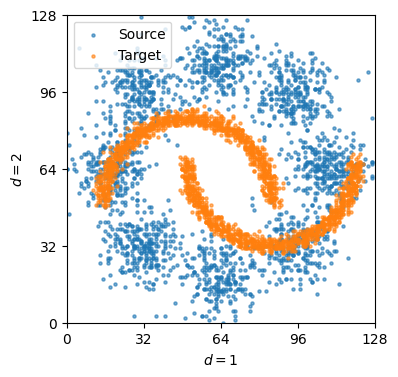

In [5]:
vocab_size = 128
source_loader = get_loaders(names="mixgaussian", n_grid_points=vocab_size, n_samples=2000, batch_size=2000)
target_loader = get_loaders(names="moon", n_grid_points=vocab_size, n_samples=2000, batch_size=2000)

source_iter = iter(source_loader)
target_iter = iter(target_loader)
samples_train = next(source_iter)[0]
samples_target = next(target_iter)[0]

plt.figure(figsize=(4, 4))
plt.xlim(0,vocab_size)
plt.ylim(0,vocab_size)
plt.scatter(samples_train[:, 0], samples_train[:, 1], s=5, alpha=0.6, label="Source")
plt.scatter(samples_target[:, 0], samples_target[:, 1], s=5, alpha=0.6, label="Target")
plt.xlabel("$d=1$")
plt.ylabel("$d=2$")
plt.xticks(ticks=range(0, 129, 32),labels=[str(i) for i in range(0, 129, 32)])
plt.yticks(ticks=range(0, 129, 32),labels=[str(i) for i in range(0, 129, 32)])
plt.gca().set_aspect('equal')
plt.legend()
out_dir = "./figures"
os.makedirs(out_dir, exist_ok=True)
plt.savefig(os.path.join(out_dir, "source_and_target_samples.pdf"), dpi=300, bbox_inches="tight")


## Loading Models

In [4]:
scheduler = KOConvexScheduler()  # KO scheduler
path = MixtureDiscreteProbPath(scheduler=scheduler)

pretrained_model = ToyMLP(vocab_size=vocab_size, hidden_dim=256).to(device)
target_model = ToyMLP(vocab_size=vocab_size, hidden_dim=256).to(device)
density_ratio_model = DensityRatio(vocab_size=vocab_size, hidden_dim=256).to(device)
guidance_model = PosteriorGuidance(vocab_size=vocab_size, hidden_dim=256).to(device)
pretrained_model.load_state_dict(torch.load(os.path.join("./models/big_toy/source_ckpt50.pth")))
target_model.load_state_dict(torch.load(os.path.join("./models/big_toy/target_ckpt50.pth")))
density_ratio_model.load_state_dict(torch.load(os.path.join("./models/big_toy/density_ratio_ckpt50.pth")))
wrapped_density_ratio_model = DensityRatioWrapper(density_ratio_model)
wrapped_probability_denoiser = WrappedModel(pretrained_model)
wrapped_probability_denoiser_target = WrappedModel(target_model)
p_solver = MixtureDiscreteEulerSolver(model=wrapped_probability_denoiser, path=path, vocabulary_size=vocab_size)
q_solver = MixtureDiscreteEulerSolver(model=wrapped_probability_denoiser_target, path=path, vocabulary_size=vocab_size)

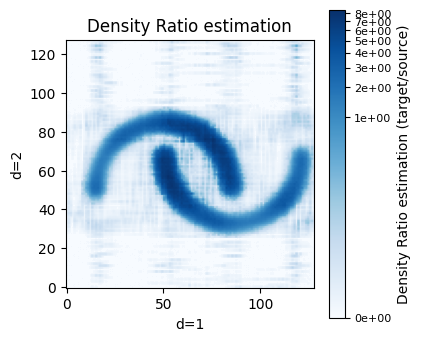

In [5]:

x = torch.arange(0, vocab_size)
y = torch.arange(0, vocab_size)
xx, yy = torch.meshgrid(x, y, indexing='ij')
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

dr = wrapped_density_ratio_model(grid).reshape(vocab_size, vocab_size).cpu().numpy()  # Ensure it's a numpy array


log_dr = np.log(dr + 1)

plt.figure(figsize=(4, 4))
norm = mcolors.PowerNorm(gamma=0.2, vmin=log_dr.min(), vmax=log_dr.max())
im = plt.imshow(log_dr.T, origin='lower', cmap='Blues', norm=norm)
cbar = plt.colorbar(im, label='Density Ratio estimation (target/source)', format='%.0e')
cbar.ax.tick_params(labelsize=8)
plt.title('Density Ratio estimation')
plt.xlabel('d=1')
plt.ylabel('d=2')
plt.show()

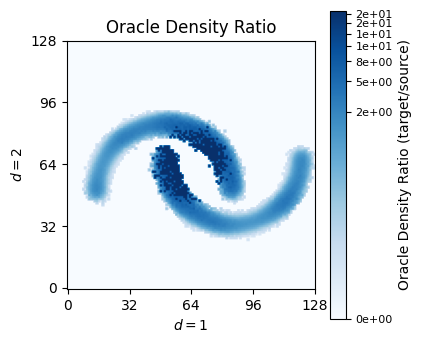

In [6]:

source_loader_vis = get_loaders(names="mixgaussian", n_grid_points=vocab_size, n_samples=1000000, batch_size=1000000)
target_loader_vis = get_loaders(names="moon", n_grid_points=vocab_size, n_samples=1000000, batch_size=1000000)


source_iter_vis = iter(source_loader_vis)
target_iter_vis = iter(target_loader_vis)

source_samples_vis = next(source_iter_vis)[0].numpy()
target_samples_vis = next(target_iter_vis)[0].numpy()


source_hist = np.zeros((vocab_size, vocab_size))
target_hist = np.zeros((vocab_size, vocab_size))

for x, y in source_samples_vis:
    source_hist[x, y] += 1
for x, y in target_samples_vis:
    target_hist[x, y] += 1

source_density = source_hist / source_hist.sum()
target_density = target_hist / target_hist.sum()

eps = 1e-16
density_ratio = target_density / (source_density + eps)
density_ratio = np.clip(density_ratio, 0, 1e8)

log_density_ratio = np.log(density_ratio + 1)

plt.figure(figsize=(4, 4))
norm = mcolors.PowerNorm(gamma=0.2, vmin=log_density_ratio.min(), vmax=log_density_ratio.max())
im = plt.imshow(log_density_ratio.T, origin='lower', cmap='Blues', norm=norm)
cbar = plt.colorbar(label='Oracle Density Ratio (target/source)', format='%.0e')
cbar.ax.tick_params(labelsize=8)
plt.title('Oracle Density Ratio')
plt.xlabel('$d=1$')
plt.ylabel('$d=2$')
plt.xticks(ticks=range(0, 129, 32),labels=[str(i) for i in range(0, 129, 32)])
plt.yticks(ticks=range(0, 129, 32),labels=[str(i) for i in range(0, 129, 32)])
plt.show()

## Sampling with Different Tuning Parameter

In [7]:
nfe = 128
step_size = 1 / nfe
safe_sampling = True
n_samples = 1000
dim = 2
epsilon = 1e-3 # early stopping
x_init = torch.randint(size=(n_samples, dim), high=vocab_size, device=device)



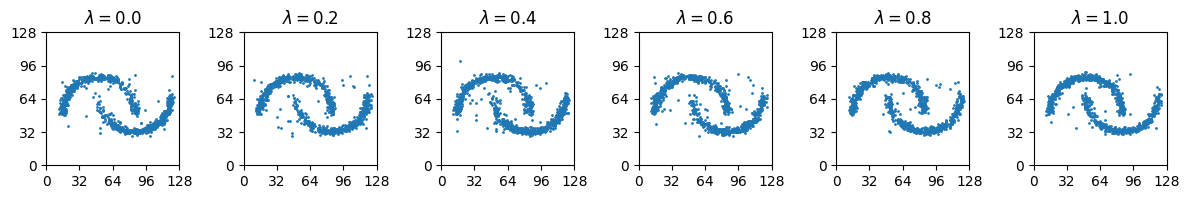

In [8]:
step_size = 1 / 64
tuning_list = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
plt.figure(figsize=(12,3.0))
axes = []
for i, loss_tuning in enumerate(tuning_list):
    plt.subplot(1, len(tuning_list), i+1)
    log_guidance_model = PosteriorGuidance(vocab_size=vocab_size, hidden_dim=256).to(device)
    ckpt_path = os.path.join(
        "./models/big_toy/guidance_model",
        f"{loss_tuning:.1f}".replace('.', '_'),
        "guidance_ckpt100.pth"
    )
    log_guidance_model.load_state_dict(torch.load(ckpt_path, map_location=device))
    guidance_model = GuidanceModelWrapper(log_guidance_model).to(device)
    guided_posterior_model = WrappedConditionalProb(wrapped_probability_denoiser, guidance_model)
    solver = MixtureDiscreteEulerSolver(model=guided_posterior_model, path=path, vocabulary_size=vocab_size)
    sol = solver.sample(x_init=x_init, # (n_samples, 2)
            step_size=step_size, 
            verbose=False, 
            return_intermediates=False)
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0,vocab_size)
    plt.ylim(0,vocab_size)
    plt.scatter(sol[:,0],sol[:,1],s=1,rasterized=True)
    plt.yticks(ticks=range(0, vocab_size + 1, 32),labels=[str(i) for i in range(0, vocab_size + 1, 32)])
    plt.xticks(ticks=range(0, vocab_size + 1, 32),labels=[str(i) for i in range(0, vocab_size + 1, 32)])
    axes.append(plt.gca())
    plt.title(r'$ \lambda = {:.1f}$'.format(loss_tuning))
    # plt.grid(True)
    plt.tight_layout()
out_dir = "./figures"
os.makedirs(out_dir, exist_ok=True)
plt.savefig(os.path.join(out_dir, "sampling_tuning_all.pdf"), dpi=300, bbox_inches="tight")



## Estimating ELBO with Different Hyperparameter

tuning = 0.0: Sample 1 of 5
tuning = 0.0: Sample 2 of 5
tuning = 0.0: Sample 3 of 5
tuning = 0.0: Sample 4 of 5
tuning = 0.0: Sample 5 of 5
tuning = 0.2: Sample 1 of 5
tuning = 0.2: Sample 2 of 5
tuning = 0.2: Sample 3 of 5
tuning = 0.2: Sample 4 of 5
tuning = 0.2: Sample 5 of 5
tuning = 0.4: Sample 1 of 5
tuning = 0.4: Sample 2 of 5
tuning = 0.4: Sample 3 of 5
tuning = 0.4: Sample 4 of 5
tuning = 0.4: Sample 5 of 5
tuning = 0.6: Sample 1 of 5
tuning = 0.6: Sample 2 of 5
tuning = 0.6: Sample 3 of 5
tuning = 0.6: Sample 4 of 5
tuning = 0.6: Sample 5 of 5
tuning = 0.8: Sample 1 of 5
tuning = 0.8: Sample 2 of 5
tuning = 0.8: Sample 3 of 5
tuning = 0.8: Sample 4 of 5
tuning = 0.8: Sample 5 of 5
tuning = 1.0: Sample 1 of 5
tuning = 1.0: Sample 2 of 5
tuning = 1.0: Sample 3 of 5
tuning = 1.0: Sample 4 of 5
tuning = 1.0: Sample 5 of 5


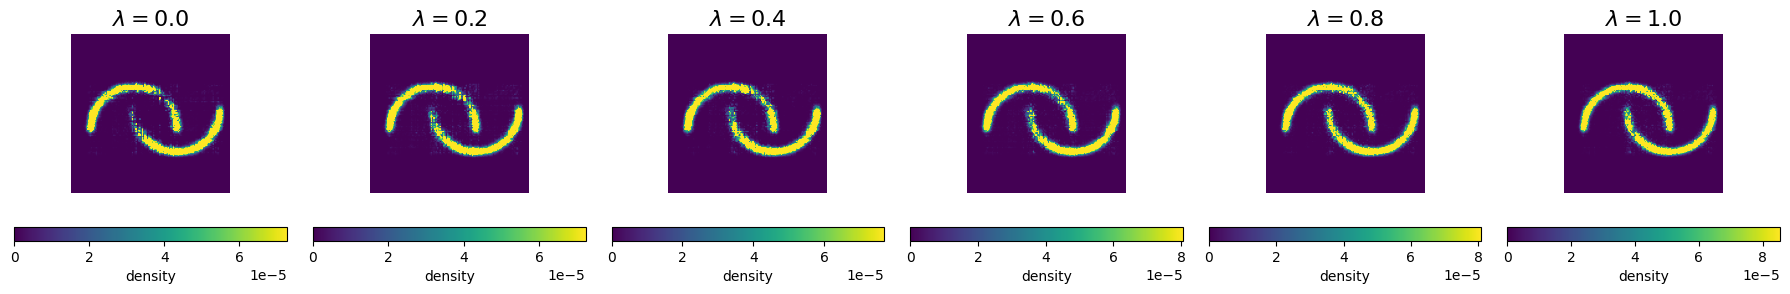

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,3.0))
axes = []
for i, loss_tuning in enumerate(tuning_list):
    plt.subplot(1, len(tuning_list), i+1)
    log_guidance_model = PosteriorGuidance(vocab_size=vocab_size, hidden_dim=256).to(device)
    ckpt_path = os.path.join(
        "./models/big_toy/guidance_model",
        f"{loss_tuning:.1f}".replace('.', '_'),
        "guidance_ckpt100.pth"
    )
    log_guidance_model.load_state_dict(torch.load(ckpt_path, map_location=device))
    guidance_model = GuidanceModelWrapper(log_guidance_model).to(device)
    guided_posterior_model = WrappedConditionalProb(wrapped_probability_denoiser, guidance_model)
    guided_logits_model = LogitsModelWrapper(guided_posterior_model)

    n_discretization = 1024  # Time discretization of integration interval
    n_samples = 5  # Number of samples to approximate the expectation on X_t ~ p_t(\cdot| x_1)

    # Generalized KL function (will use it to compute the elbo)
    generalized_kl_fn = MixturePathGeneralizedKL(
        path = path,
        reduction ='none'
    )

    # Grid of vocab_size X vocab_size
    grid = torch.meshgrid(
        torch.arange(0, vocab_size, device=device),
        torch.arange(0, vocab_size, device=device),
        indexing='ij'
    )
    x_1 = torch.stack(
        [grid[0].reshape(-1), grid[1].reshape(-1)],
        dim=1
    )

    # Time discretization
    discretization = (
        torch.linspace(0, 1, n_discretization + 1, device=device)[:-1]
        .view(-1, 1)
        .repeat(1, x_1.shape[0])
    )
    # [0, 1/1024, 2/1024, ..., 1023/1024]

    elbo = torch.zeros(size=(x_1.shape[0],), device=device)

    with torch.no_grad():
        # ELBO(x₁) = ∫₀¹ 𝔼[X_t~p_t(·|x₁)] [-KL_term(x_t, x₁, t)] dt
        for _ in range(n_samples):
            # Lower variance estimator for time discretization
            discretization = discretization + torch.rand(
                size=(1, x_1.shape[0]), device=device
            )
            discretization = discretization % 1 # make sure t in [0, 1)
            discretization = discretization * (1 - epsilon)
            
            for t in discretization:
                # sample X_t ~ p_t(\cdot| x_1)
                x_0 = torch.randint(size=x_1.shape, high=vocab_size, device=device)

                
                x_t = path.sample(t=t, x_0=x_0, x_1=x_1).x_t
                
                logits = guided_logits_model(x_t, t)
                
                # compute ELBO
                elbo += -generalized_kl_fn(
                    logits=logits, x_1=x_1, x_t=x_t, t=t
                ).sum(dim=1)
            print(f"tuning = {loss_tuning:.1f}: Sample {_ + 1} of {n_samples}")
        elbo /= n_discretization * n_samples # compute the integral

    # Remember that log_q(x_1) >= ELBO(x_1)
    probability_lower_bound = torch.exp(elbo)
    cmin = torch.quantile(probability_lower_bound, 0).item()
    cmax = torch.quantile(probability_lower_bound, 0.95).item()

    norm = cm.colors.Normalize(vmin=cmin, vmax=cmax)
    plt.imshow(
        probability_lower_bound.reshape(vocab_size, vocab_size).T.cpu(), 
        origin='lower', cmap='viridis', norm=norm
    )
    plt.gca().axis("off")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=plt.gca(), orientation='horizontal', label='density')
    plt.title(r'$\lambda={:.1f}$'.format(loss_tuning), fontsize=16)
plt.tight_layout()
plt.show()
out_dir = "./figures"
os.makedirs(out_dir, exist_ok=True)
plt.savefig(os.path.join(out_dir, "density_tuning_all.pdf"), dpi=300, bbox_inches="tight")

## Oracle ELBO Estimation

Sample 1 of 5
Sample 2 of 5
Sample 3 of 5
Sample 4 of 5
Sample 5 of 5


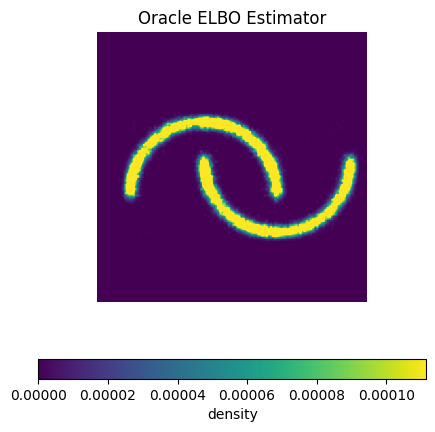

In [10]:

n_discretization = 1024  # Time discretization of integration interval
n_samples = 5  # Number of samples to approximate the expectation on X_t ~ p_t(\cdot| x_1)

# Generalized KL function (will use it to compute the elbo)
generalized_kl_fn = MixturePathGeneralizedKL(
    path = path,
    reduction ='none'
)

# Grid of vocab_size X vocab_size
grid = torch.meshgrid(
    torch.arange(0, vocab_size, device=device),
    torch.arange(0, vocab_size, device=device),
    indexing='ij'
)
x_1 = torch.stack(
    [grid[0].reshape(-1), grid[1].reshape(-1)],
    dim=1
)

# Time discretization
discretization = (
    torch.linspace(0, 1, n_discretization + 1, device=device)[:-1]
    .view(-1, 1)
    .repeat(1, x_1.shape[0])
)

elbo = torch.zeros(size=(x_1.shape[0],), device=device)

with torch.no_grad():
    for _ in range(n_samples):
        # Lower variance estimator for time discretization
        discretization = discretization + torch.rand(
            size=(1, x_1.shape[0]), device=device
        )
        discretization = discretization % 1
        discretization = discretization * (1 - epsilon)
        
        for t in discretization:
            # sample X_t ~ p_t(\cdot| x_1)
            x_0 = torch.randint(size=x_1.shape, high=vocab_size, device=device)
            
            x_t = path.sample(t=t, x_0=x_0, x_1=x_1).x_t
            
            logits = target_model(x_t, t)
            
            # compute ELBO
            elbo += -generalized_kl_fn(
                logits=logits, x_1=x_1, x_t=x_t, t=t
            ).sum(dim=1)
        print(f"Sample {_ + 1} of {n_samples}")
    elbo /= n_discretization * n_samples

# Remember that log_q(x_1) >= ELBO(x_1)
probability_lower_bound = torch.exp(elbo)

cmin = torch.quantile(probability_lower_bound, 0).item()
cmax = torch.quantile(probability_lower_bound, 0.95).item()

norm = cm.colors.Normalize(vmin=cmin, vmax=cmax)

plt.figure(figsize=(5, 5))
plt.imshow(
    probability_lower_bound.reshape(vocab_size, vocab_size).T.cpu(), 
    origin='lower', cmap='viridis', norm=norm
)
plt.gca().axis("off")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=plt.gca(), orientation='horizontal', label='density')
plt.title("Oracle ELBO Estimator")
plt.show()